In [83]:
%matplotlib inline
import os
import numpy as np
import matplotlib as mpl

import readdy_learn.analyze.analyze as ana
import readdy_learn.analyze.basis as basis
import pickle

import pynumtools.kmc as kmc

#mpl.rcParams['figure.figsize'] = (13, 13)
import matplotlib.pyplot as plt
import scipy.signal as ss
from readdy_learn.example.regulation_network import RegulationNetwork

def plot_cv_results2(cv):
    l1_dict = ana.cluster_along_arg(cv.result, "l1_ratio", cv.l1_ratios)
    alphas_dict = {}
    for l1_ratio in l1_dict.keys():
        alphas_dict[l1_ratio] = ana.cluster_along_arg(l1_dict[l1_ratio], "alpha", cv.alphas)
        
    for l1_ratio in l1_dict.keys():
        scores_mean = []
        scores_err = []
        for alpha in cv.alphas:
            cv_data = alphas_dict[l1_ratio][alpha]
            scores = []
            for idx, d in enumerate(cv_data):
                offset = alphas_dict[l1_ratio][cv.alphas[0]][idx]['scores'][0] + 1
                scores.append(d['scores'][0] - offset)
            scores = np.array(scores)
            scores_mean.append(np.mean(scores))
            scores_err.append(np.std(scores))
        scores_mean = np.array(scores_mean)
        scores_err = np.array(scores_err)
        #print(scores_mean)
        plt.errorbar(cv.alphas, -scores_mean, yerr=scores_err, label='score l1={}'.format(l1_ratio))
    
    plt.ylabel('score')
    plt.xlabel('$\\alpha$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()

def plot_cv_results3(cv):
    l1_dict = ana.cluster_along_arg(cv.result, "l1_ratio", cv.l1_ratios)
    alphas_dict = {}
    for l1_ratio in l1_dict.keys():
        alphas_dict[l1_ratio] = ana.cluster_along_arg(l1_dict[l1_ratio], "alpha", cv.alphas)
    
    cmap = dict()
    couleurs=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    l1_index = 0
    for l1_ratio in l1_dict.keys():
        scores_per_traj = []
        for alpha in cv.alphas:
            cv_data = alphas_dict[l1_ratio][alpha]
            scores = []
            n_traj = len(cv_data)
            for d in cv_data:
                scores.append(d['scores'][0])
            scores = np.array(scores)
            scores_per_traj.append(scores)
        scores_per_traj = np.array(scores_per_traj)
        current_color = couleurs[l1_index % len(couleurs)]
        for i in range(n_traj):
            if i==0:
                plt.plot(cv.alphas, -scores_per_traj[:,i], ".",label='score l1={}'.format(l1_ratio), color=current_color)
            else:
                plt.plot(cv.alphas, -scores_per_traj[:,i], ".",color=current_color)
        l1_index += 1
                
    
    plt.ylabel('score')
    plt.xlabel('$\\alpha$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()

In [184]:
def do_n(n):
    traj_indices = [1, 2]
    regulation_network = RegulationNetwork()
    regulation_network.timestep = 1.5e-2
    regulation_network.noise_variance = 5e-5
    regulation_network.realisations = 1.
    print("noise variance {}".format(regulation_network.noise_variance))
    
    analysis = regulation_network.generate_analysis_object(fname_prefix="tryout", fname_postfix=str(n))
    
    for i in range(len(regulation_network.initial_states)):
        print("traj {}".format(i))
        t = analysis.generate_or_load_traj_lma(i, regulation_network.target_time,
                                               noise_variance=regulation_network.noise_variance,
                                               realizations=regulation_network.realisations)
        t.persist()
    regulation_network.compute_gradient_derivatives(analysis)
    
    print("noise variance: {}".format(regulation_network.noise_variance))
    print("target time: {}".format(regulation_network.target_time))
    print("lma realizations: {}".format(regulation_network.realisations))
    print("timestep: {}".format(regulation_network.timestep))
    print("initial states:")
    for init in regulation_network.initial_states:
        print("\t{}".format(init))
    
    alphas = np.logspace(-5., -1., num=30)
    l1_ratios = np.linspace(0., 1., num=5)
    #alphas = np.logspace(-5, 0, num=3)
    #l1_ratios = np.linspace(0.,1., num=2)
    cv_res = analysis.elastic_net_cv(traj_indices, alphas=alphas, l1_ratios=l1_ratios, 
                                 recompute=False, tol=1e-15)
    
    alpha, l1_ratio, score = ana.best_params(cv_res)
    print("got alpha={}, l1_ratio={}, score={}".format(alpha, l1_ratio, score))
    
    est_rates = analysis.solve(traj_indices, alpha, l1_ratio, tol=1e-15)
    
    lsq_rates = analysis.least_squares(traj_indices, tol=1e-15, recompute=True)
    
    print("sum(desired_rates)={}".format(np.sum(regulation_network.desired_rates)))
    print("sum(est_rates)={}".format(np.sum(est_rates)))
    print("sum(lsq_rates)={}".format(np.sum(lsq_rates)))
        
    return cv_res, est_rates, lsq_rates, regulation_network.desired_rates, analysis

In [191]:
cv_res, est_rates, lsq_rates, desired_rates, analysis = do_n(17)

noise variance 5e-05
traj 0
traj 1
traj 2
traj 3
traj 4
traj 5
noise variance: 5e-05
target time: 3.0
lma realizations: 1.0
timestep: 0.015
initial states:
	[[1 0 0 1 0 0 1 0 0]]
	[[1 2 0 1 0 3 1 0 0]]
	[[1.  1.  2.  1.  0.  2.5 1.  0.  2. ]]
	[[1 1 2 1 0 0 1 3 0]]
	[[1 2 0 1 0 3 1 0 1]]
	[[1.  0.  2.  1.  0.  2.5 1.  0.5 0. ]]


HBox(children=(HBox(children=(Label(value=' 0'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=300), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

got alpha=0.0016102620275609393, l1_ratio=1.0, score=0.7633482946429531
optimization problem did exit successfully (alpha=0.0016102620275609393, lambda=1.0)!
status 0: Optimization terminated successfully.
152 / 30000 iterations
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
182 / 30000 iterations
sum(desired_rates)=39.400000000000006
sum(est_rates)=37.24973865474033
sum(lsq_rates)=39.05517068255551


# 100 points, 5 trajs, no noise

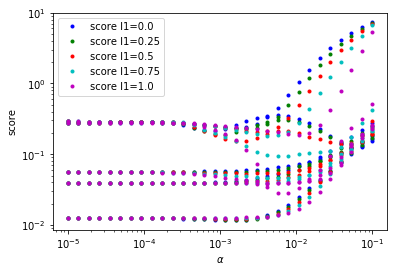

In [64]:
plot_cv_results3(cv_res)

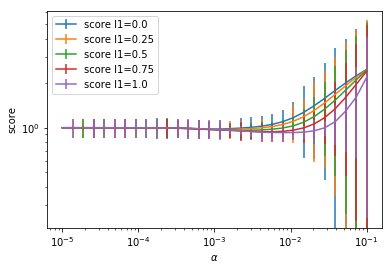

In [84]:
plot_cv_results2(cv_res)

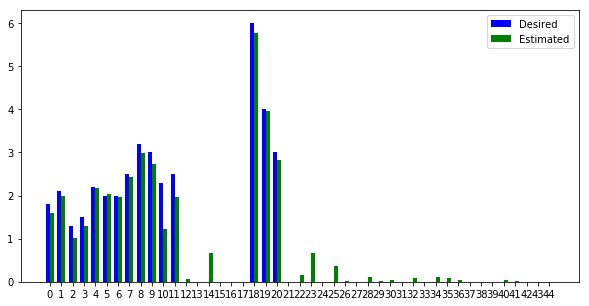

In [66]:
ana.plot_rates_bar(desired_rates, lsq_rates)

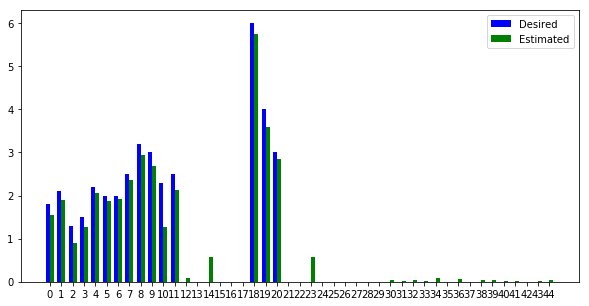

In [67]:
ana.plot_rates_bar(desired_rates, est_rates)

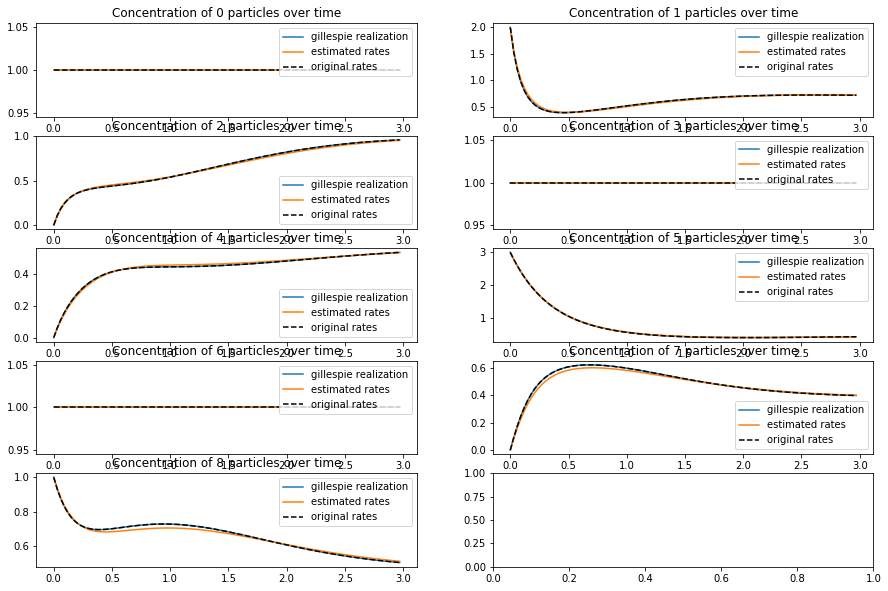

In [72]:
analysis.plot_results(4, est_rates)

# 150 points, 5 trajs, no noise

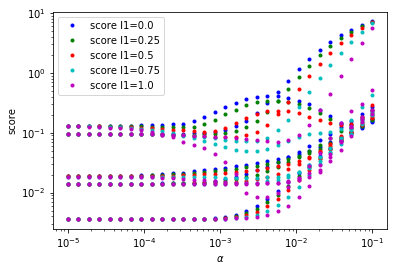

In [87]:
plot_cv_results3(cv_res)

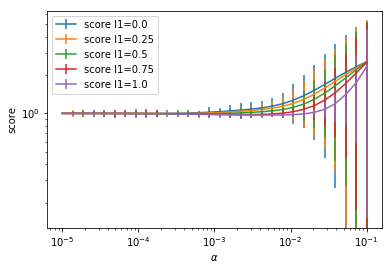

In [88]:
plot_cv_results2(cv_res)

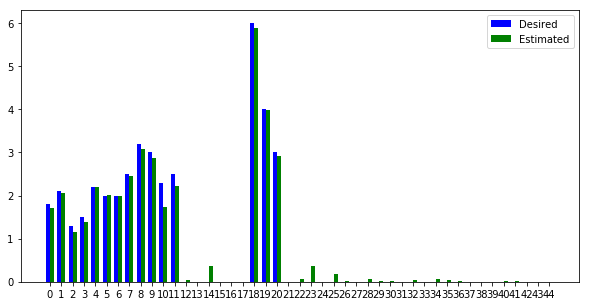

In [89]:
ana.plot_rates_bar(desired_rates, lsq_rates)

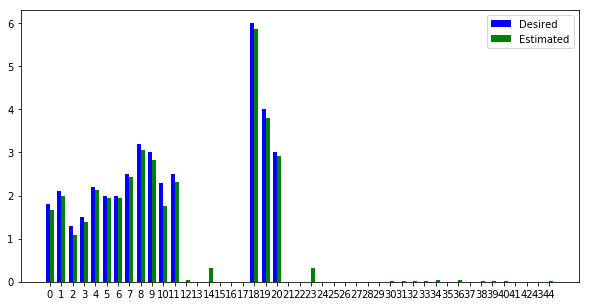

In [90]:
ana.plot_rates_bar(desired_rates, est_rates)

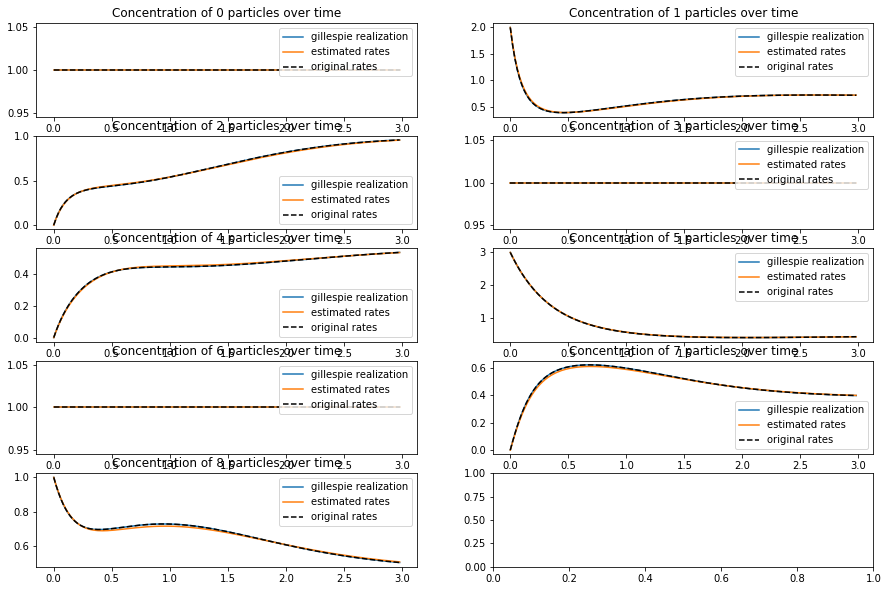

In [91]:
analysis.plot_results(4, est_rates)

# 200 points, 5 trajs, nonoise

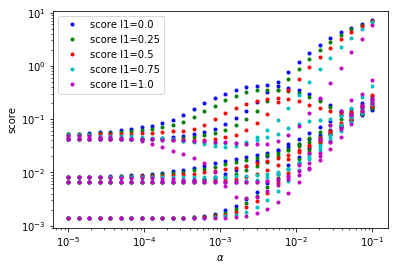

In [94]:
plot_cv_results3(cv_res)

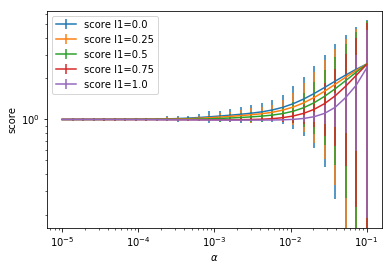

In [95]:
plot_cv_results2(cv_res)

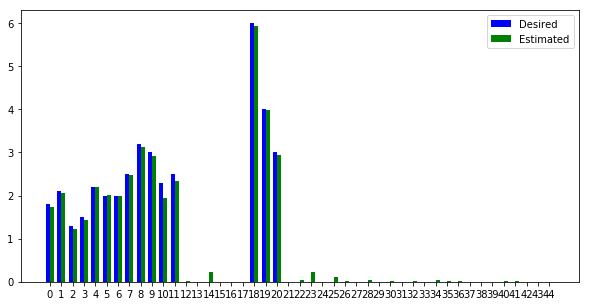

In [96]:
ana.plot_rates_bar(desired_rates, lsq_rates)

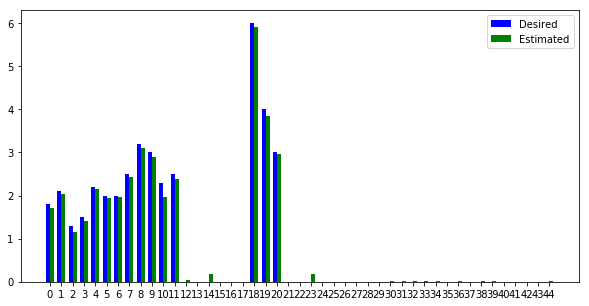

In [97]:
ana.plot_rates_bar(desired_rates, est_rates)

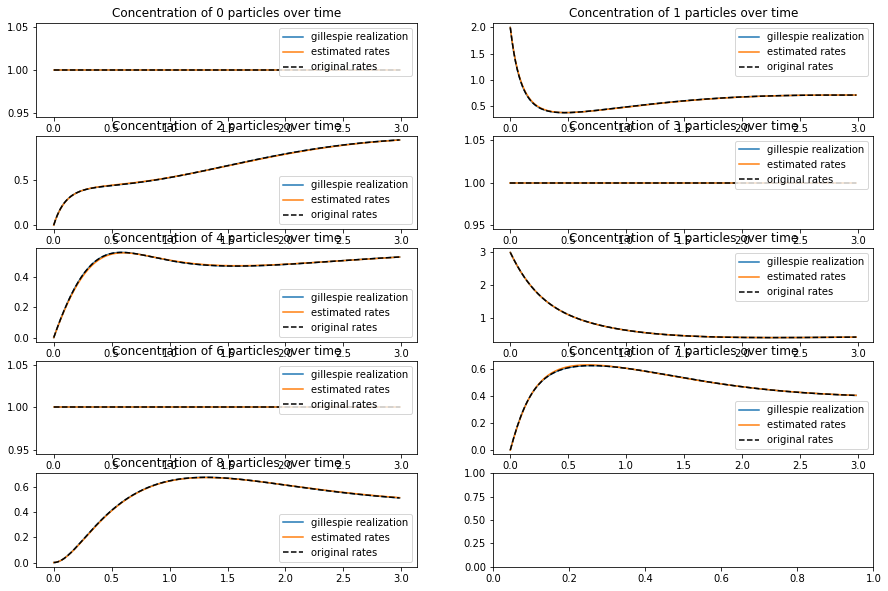

In [104]:
analysis.plot_results(1, est_rates)

# 250 points, 5 trajs, nonoise

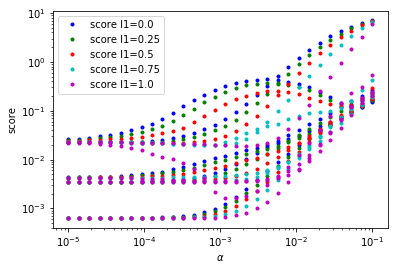

In [107]:
plot_cv_results3(cv_res)

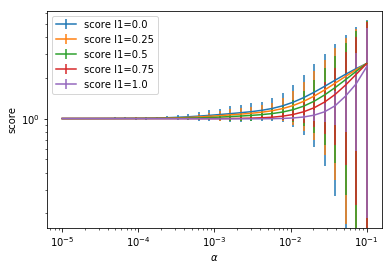

In [108]:
plot_cv_results2(cv_res)

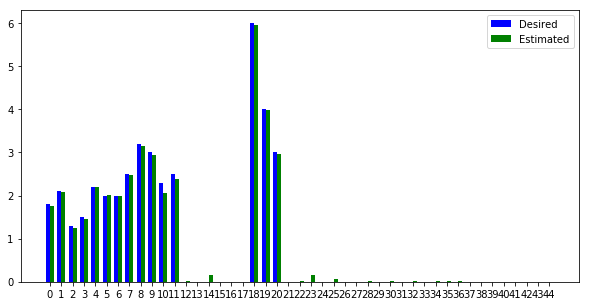

In [109]:
ana.plot_rates_bar(desired_rates, lsq_rates)

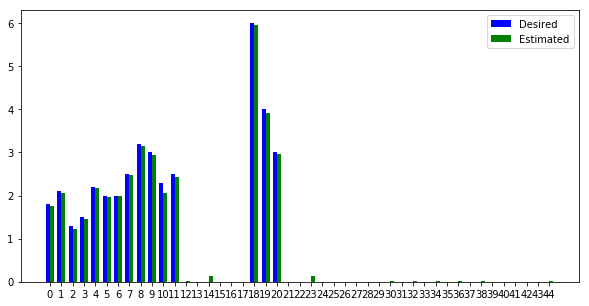

In [110]:
ana.plot_rates_bar(desired_rates, est_rates)

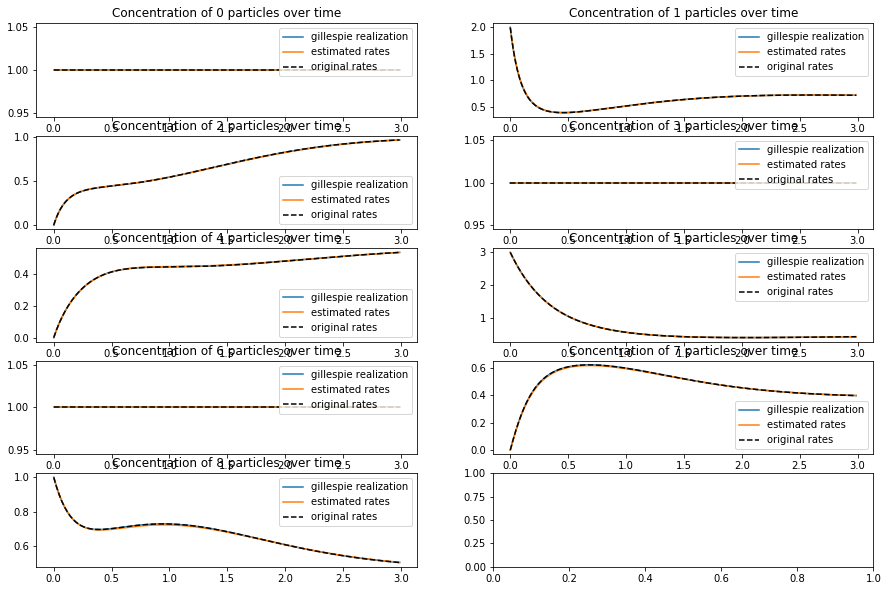

In [111]:
analysis.plot_results(4, est_rates)

# 300 points, 5 trajs, nonoise, tol=1e-15

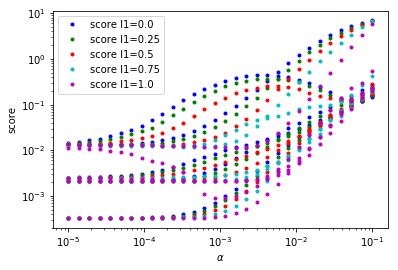

In [114]:
plot_cv_results3(cv_res)

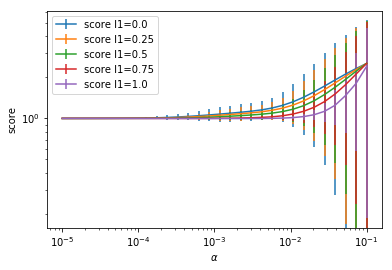

In [115]:
plot_cv_results2(cv_res)

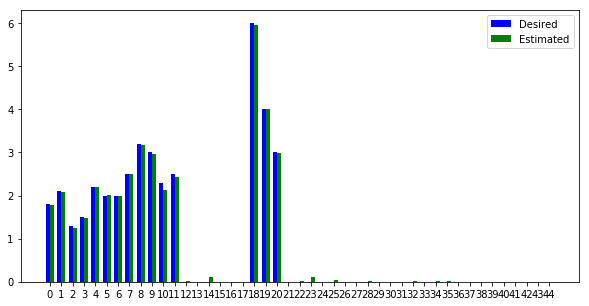

In [116]:
ana.plot_rates_bar(desired_rates, lsq_rates)

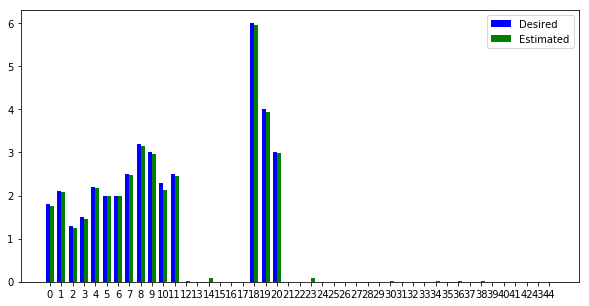

In [117]:
ana.plot_rates_bar(desired_rates, est_rates)

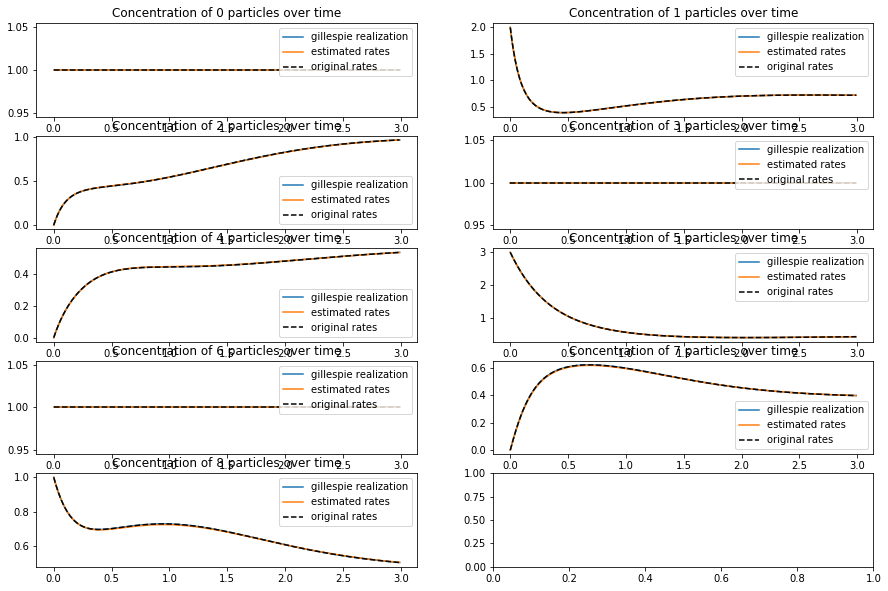

In [118]:
analysis.plot_results(4, est_rates)

# 300 points, 5 trajs, noise 1e-4, tol 1e-15

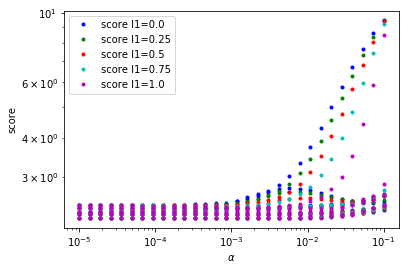

In [121]:
plot_cv_results3(cv_res)

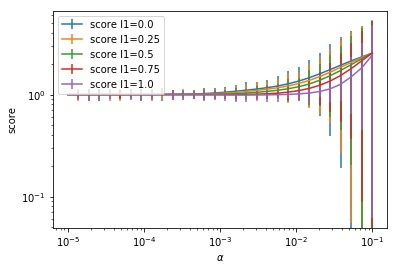

In [122]:
plot_cv_results2(cv_res)

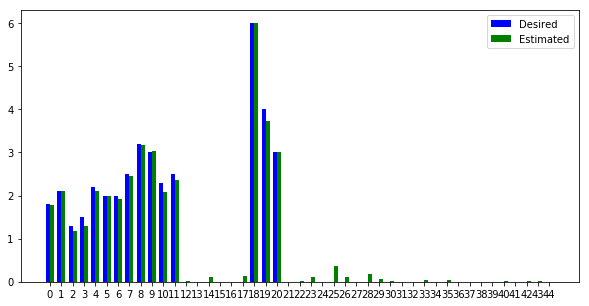

In [123]:
ana.plot_rates_bar(desired_rates, lsq_rates)

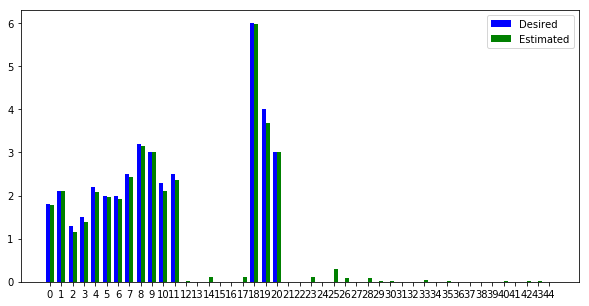

In [124]:
ana.plot_rates_bar(desired_rates, est_rates)

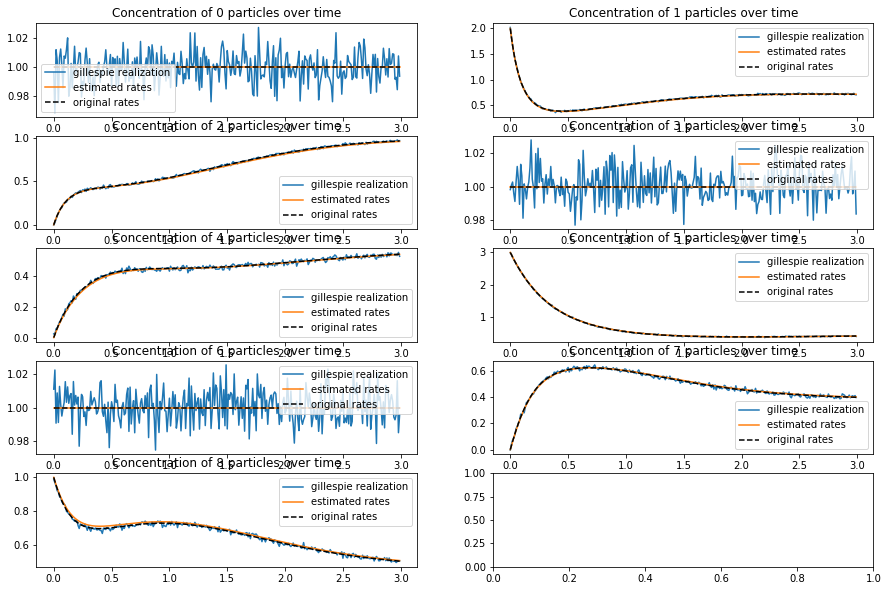

In [125]:
analysis.plot_results(4, est_rates)

# 300 points, 5 trajs, noise 1e-3, tol 1e-15

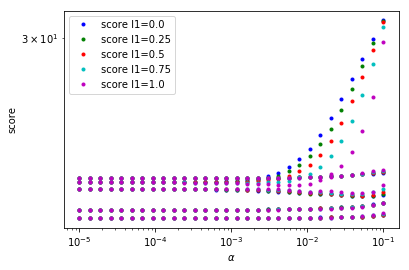

In [129]:
plot_cv_results3(cv_res)

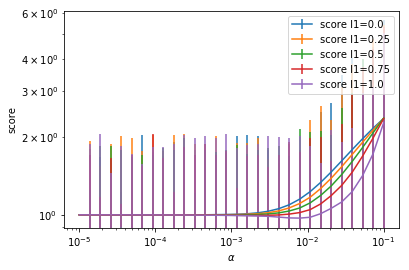

In [130]:
plot_cv_results2(cv_res)

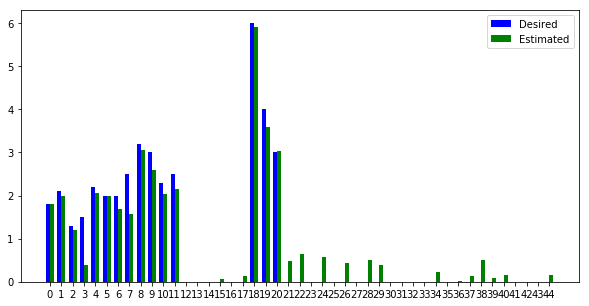

In [131]:
ana.plot_rates_bar(desired_rates, lsq_rates)

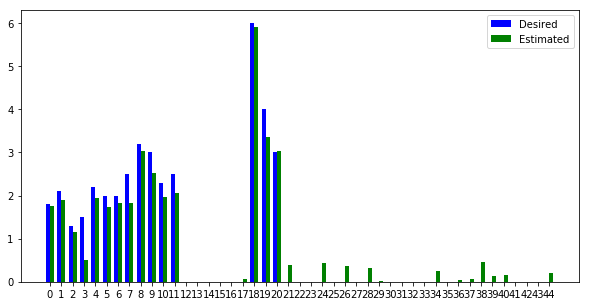

In [132]:
ana.plot_rates_bar(desired_rates, est_rates)

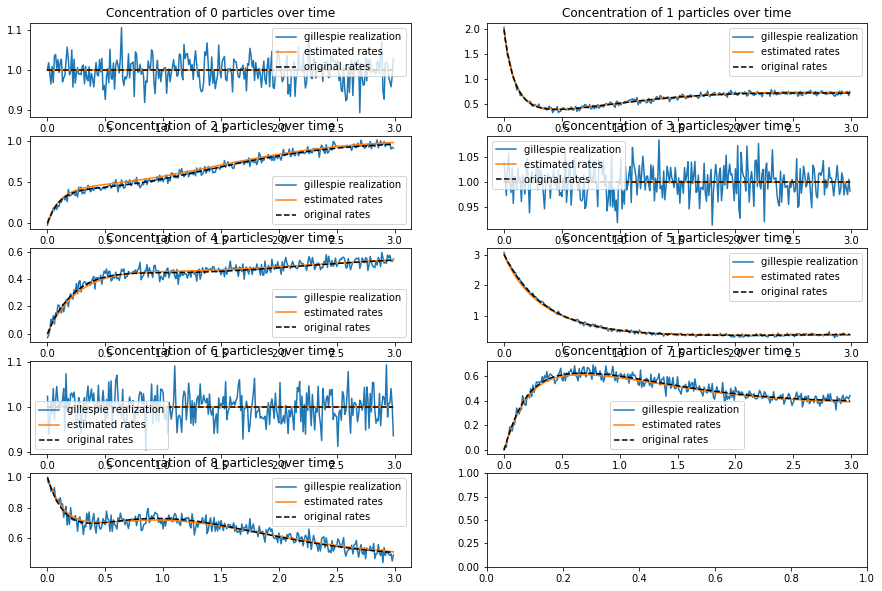

In [138]:
analysis.plot_results(4, est_rates)

# 300 points, 4 trajs(1,2,3,4), noise 1e-3, tol 1e-15

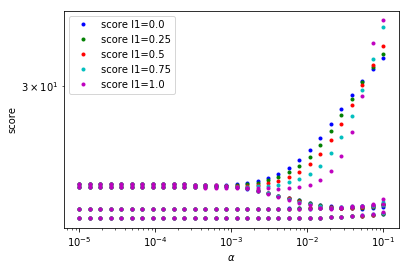

In [141]:
plot_cv_results3(cv_res)

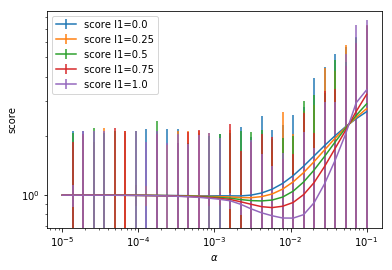

In [142]:
plot_cv_results2(cv_res)

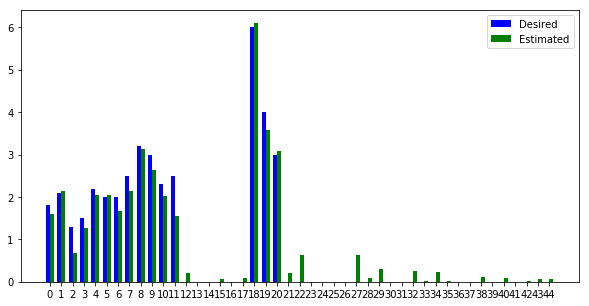

In [143]:
ana.plot_rates_bar(desired_rates, lsq_rates)

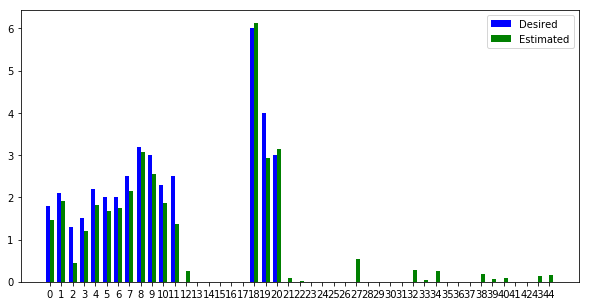

In [144]:
ana.plot_rates_bar(desired_rates, est_rates)

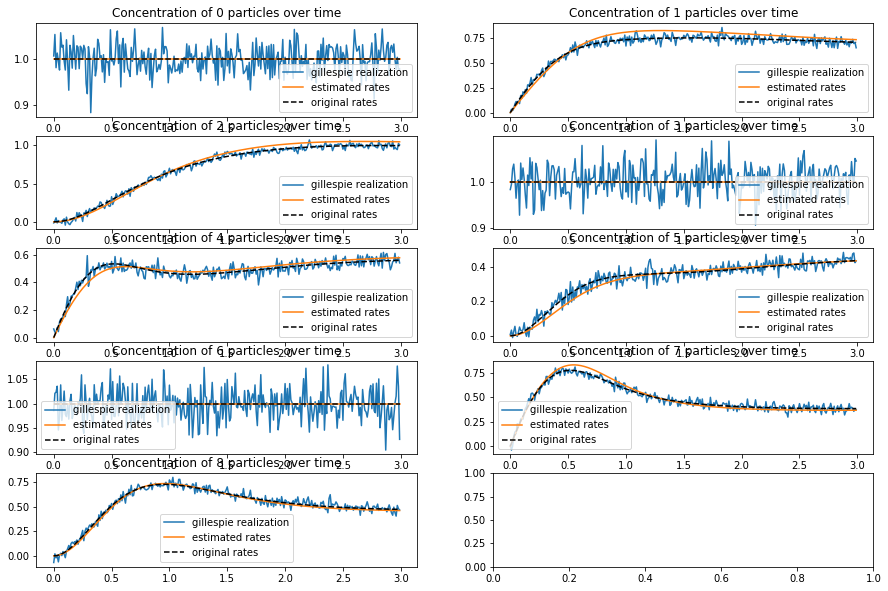

In [150]:
analysis.plot_results(0, est_rates)

# 300 points, 3 trajs (1,2,4), noise 1e-3, tol 1e-15 -> ridge won

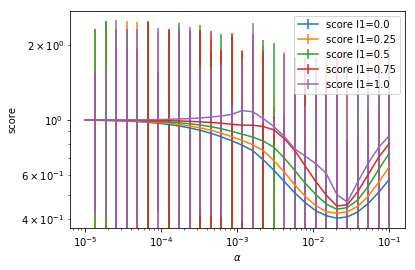

In [154]:
plot_cv_results2(cv_res)

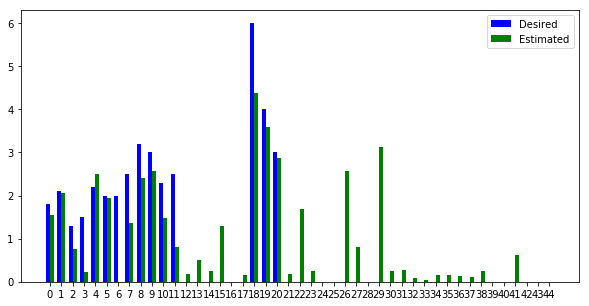

In [155]:
ana.plot_rates_bar(desired_rates, lsq_rates)

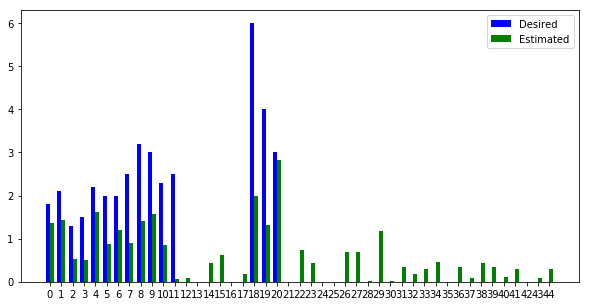

In [156]:
ana.plot_rates_bar(desired_rates, est_rates)

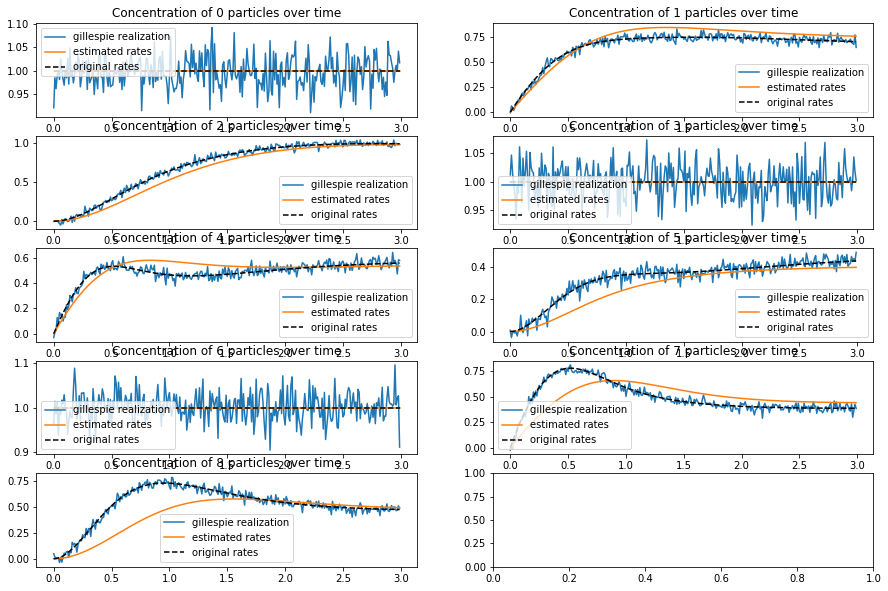

In [157]:
analysis.plot_results(0, est_rates)

# 300 points, 3 trajs (1,2,4), noise 5e-4, tol 1e-15

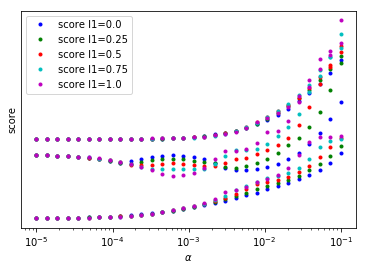

In [160]:
plot_cv_results3(cv_res)

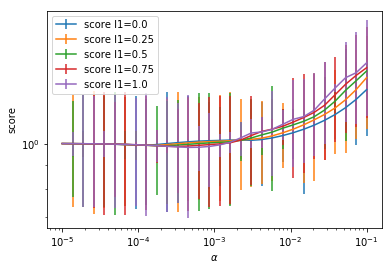

In [161]:
plot_cv_results2(cv_res)

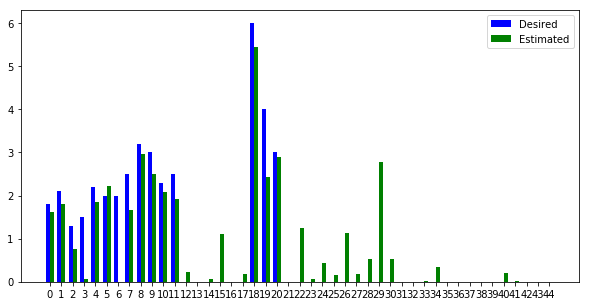

In [162]:
ana.plot_rates_bar(desired_rates, lsq_rates)

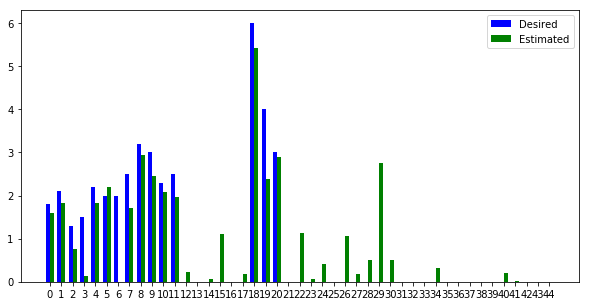

In [163]:
ana.plot_rates_bar(desired_rates, est_rates)

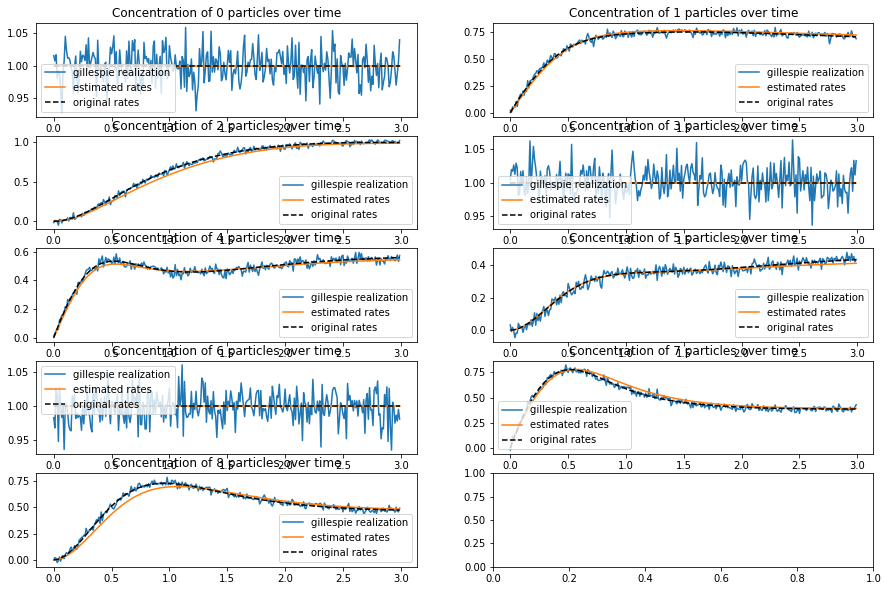

In [167]:
analysis.plot_results(0, est_rates)

# 300 points, 3 trajs (0,1,2), noise 5e-4, tol 1e-15

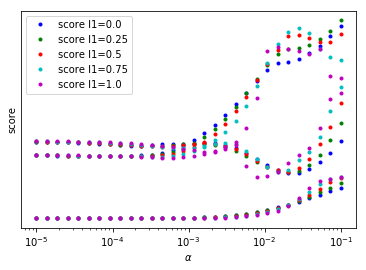

In [170]:
plot_cv_results3(cv_res)

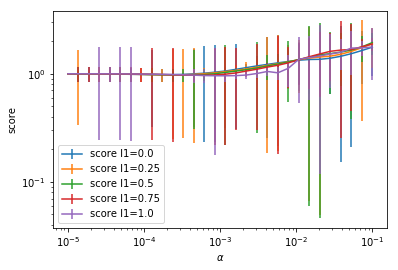

In [171]:
plot_cv_results2(cv_res)

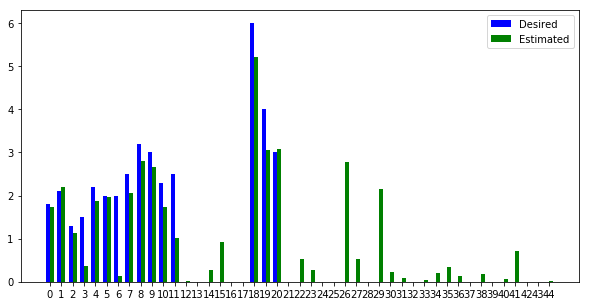

In [172]:
ana.plot_rates_bar(desired_rates, lsq_rates)

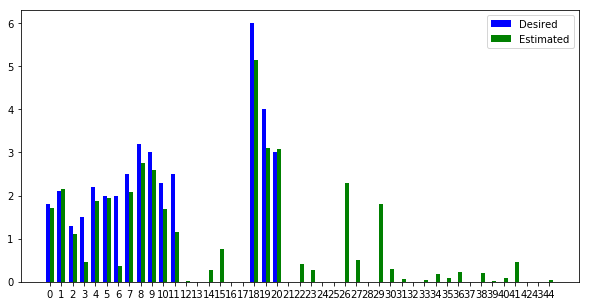

In [173]:
ana.plot_rates_bar(desired_rates, est_rates)

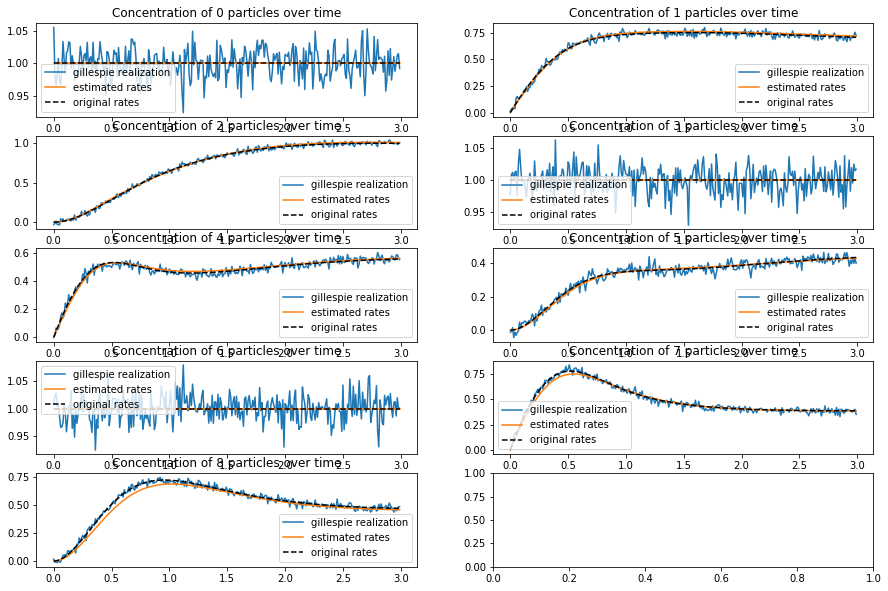

In [174]:
analysis.plot_results(0, est_rates)

# 200 points, 2 trajs (1, 2), noise 1e-4, tol 1e-15

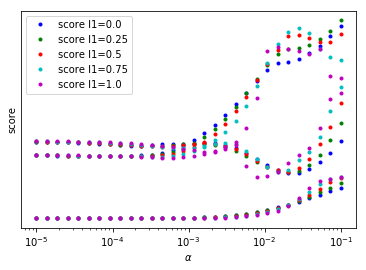

In [170]:
plot_cv_results3(cv_res)

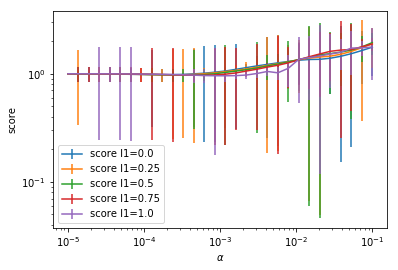

In [171]:
plot_cv_results2(cv_res)

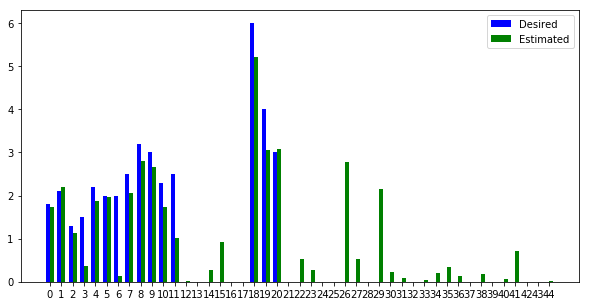

In [172]:
ana.plot_rates_bar(desired_rates, lsq_rates)

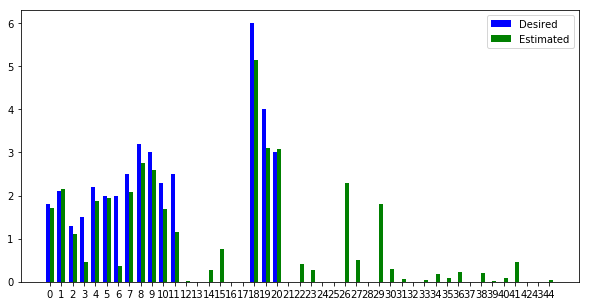

In [173]:
ana.plot_rates_bar(desired_rates, est_rates)

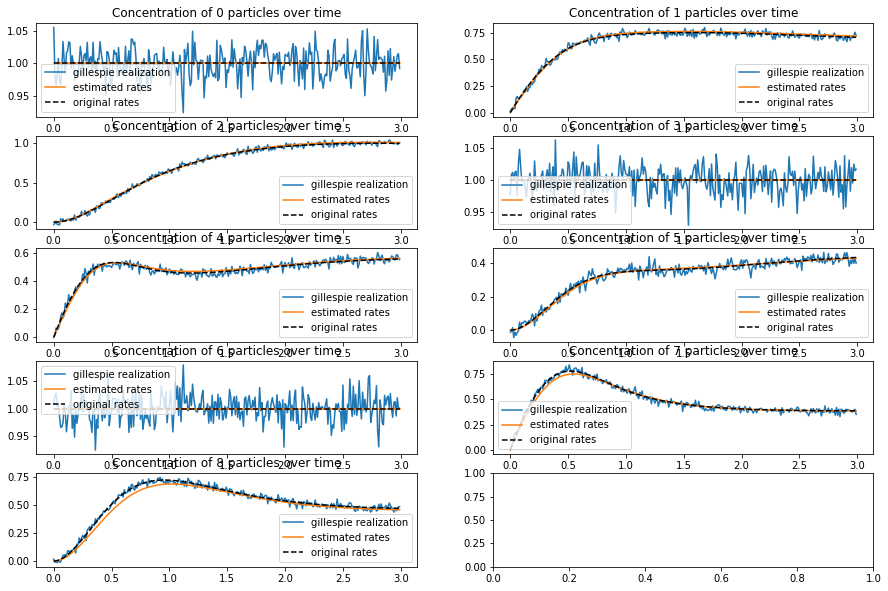

In [174]:
analysis.plot_results(0, est_rates)

# 200 points, 2 trajs (1,2), noise 1e-5, tol 1e-15

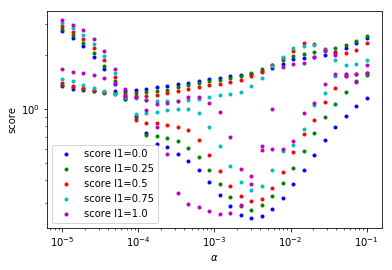

In [179]:
plot_cv_results3(cv_res)

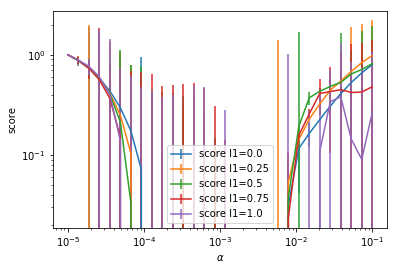

In [180]:
plot_cv_results2(cv_res)

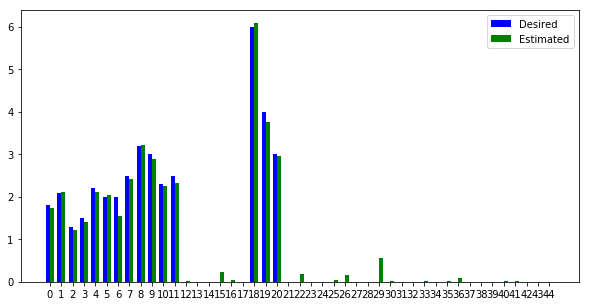

In [181]:
ana.plot_rates_bar(desired_rates, lsq_rates)

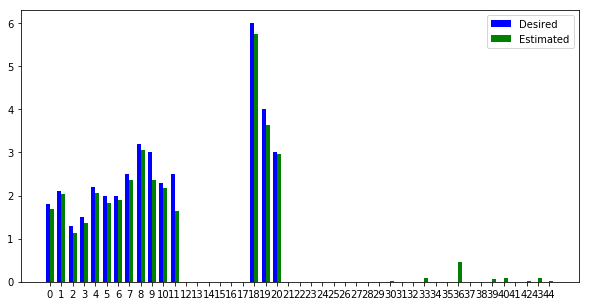

In [182]:
ana.plot_rates_bar(desired_rates, est_rates)

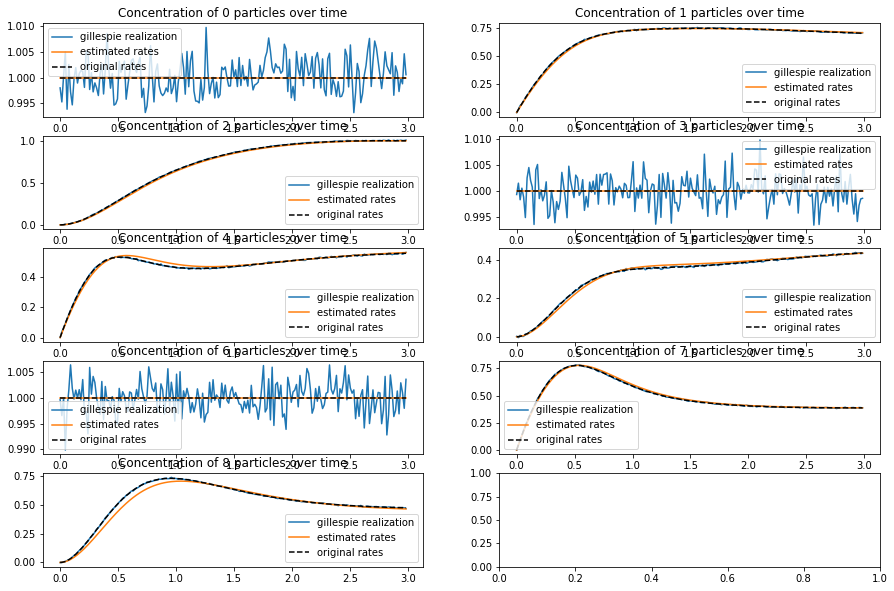

In [183]:
analysis.plot_results(0, est_rates)

# 200 points, 2 trajs (1,2), noise 5e-5, tol 1e-15

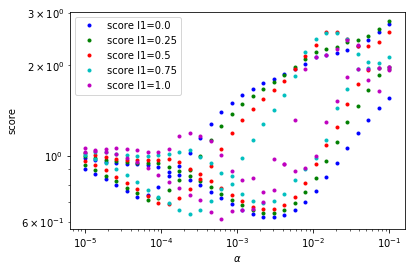

In [186]:
plot_cv_results3(cv_res)

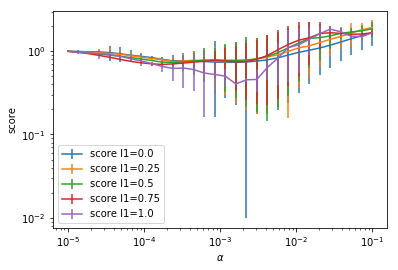

In [194]:
plot_cv_results2(cv_res)

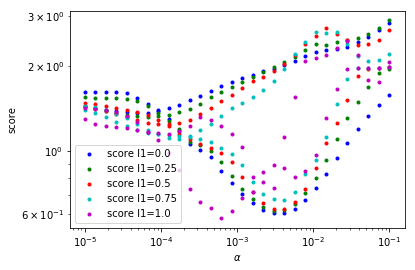

In [196]:
plot_cv_results3(cv_res)

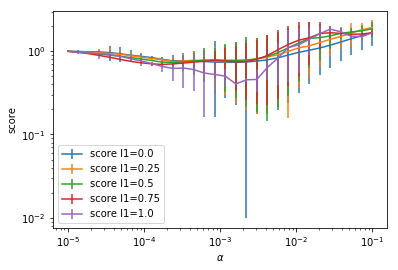

In [197]:
plot_cv_results2(cv_res)

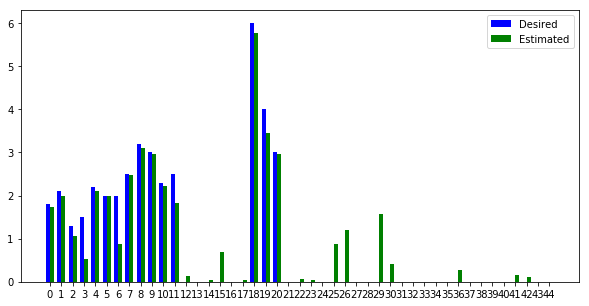

In [188]:
ana.plot_rates_bar(desired_rates, lsq_rates)

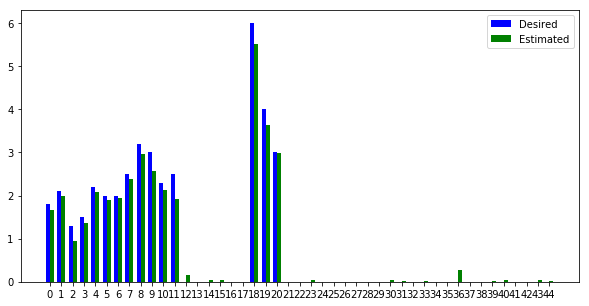

In [189]:
ana.plot_rates_bar(desired_rates, est_rates)

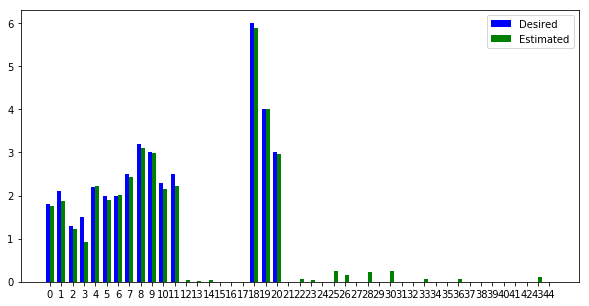

In [192]:
ana.plot_rates_bar(desired_rates, lsq_rates)

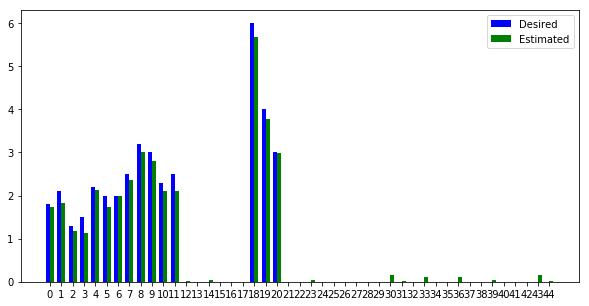

In [193]:
ana.plot_rates_bar(desired_rates, est_rates)

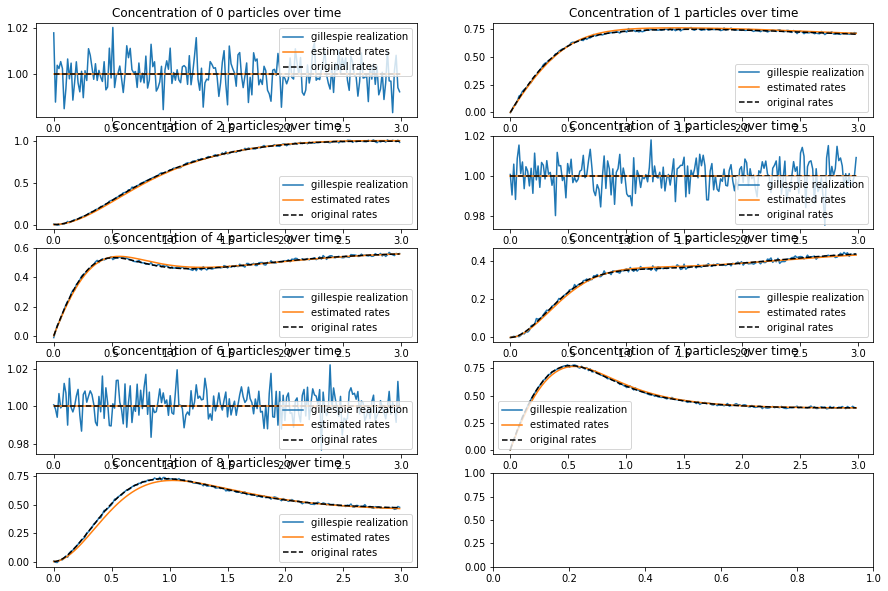

In [190]:
analysis.plot_results(0, est_rates)

# 200

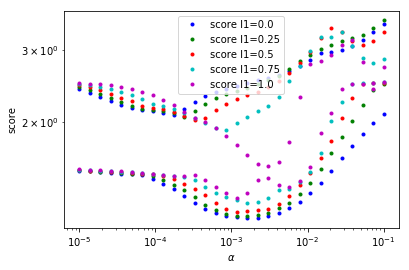

In [4]:
plot_cv_results3(cv_res)

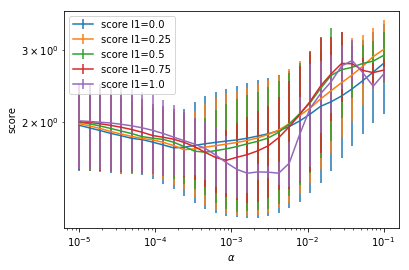

In [5]:
plot_cv_results2(cv_res)

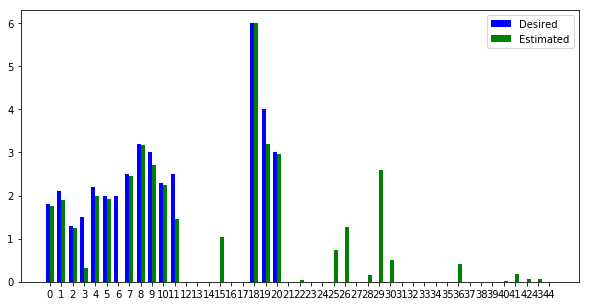

In [6]:
ana.plot_rates_bar(desired_rates, lsq_rates)

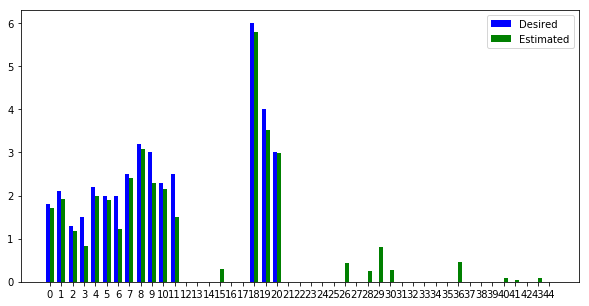

In [7]:
ana.plot_rates_bar(desired_rates, est_rates)

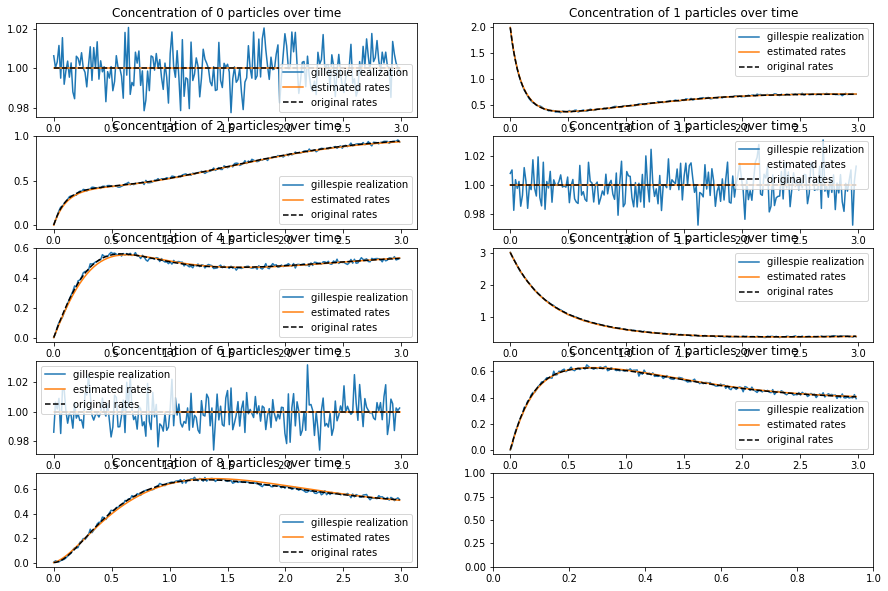

In [11]:
analysis.plot_results(1, est_rates)

# 300

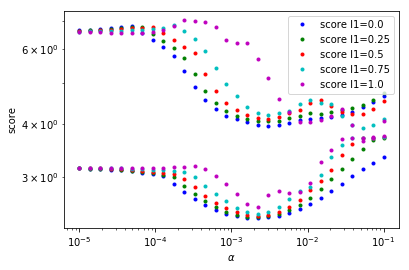

In [14]:
plot_cv_results3(cv_res)

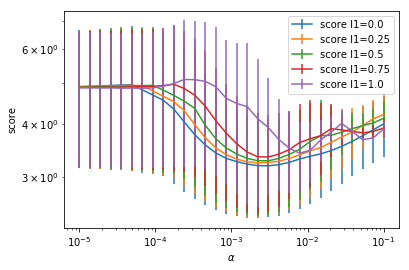

In [15]:
plot_cv_results2(cv_res)

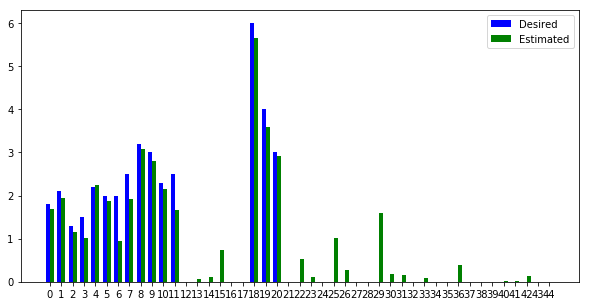

In [16]:
ana.plot_rates_bar(desired_rates, lsq_rates)

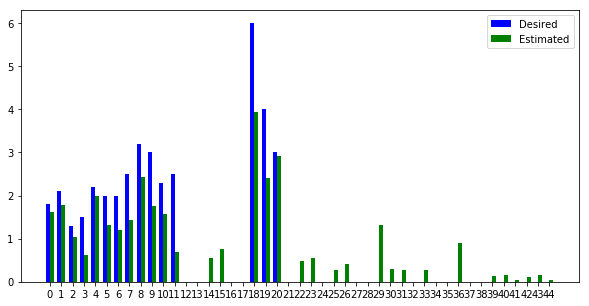

In [17]:
ana.plot_rates_bar(desired_rates, est_rates)

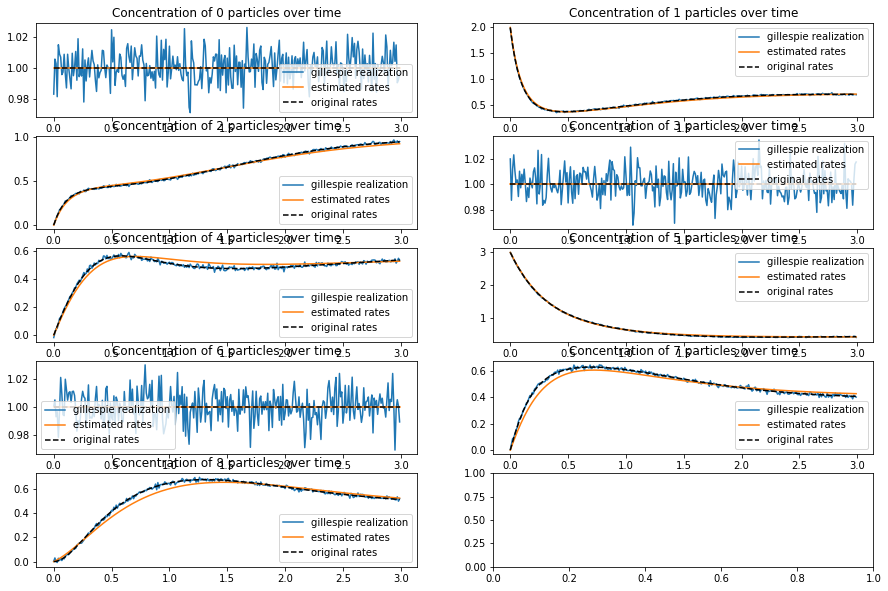

In [18]:
analysis.plot_results(1, est_rates)

# LSQ only

In [56]:
traj_indices = [0, 1, 2, 3, 4]
regulation_network = RegulationNetwork()
regulation_network.timestep = 3e-2
regulation_network.realisations = 1
regulation_network.noise_variance = 0.
print("noise variance {}".format(regulation_network.noise_variance))

analysis = regulation_network.generate_analysis_object(fname_prefix="nur_lsq", fname_postfix="100points-5trajs")

for i in range(len(regulation_network.initial_states)):
    print("traj {}".format(i))
    t = analysis.generate_or_load_traj_lma(i, regulation_network.target_time,
                                           noise_variance=regulation_network.noise_variance,
                                           realizations=regulation_network.realisations)
    t.persist()
regulation_network.compute_gradient_derivatives(analysis)

print("noise variance: {}".format(regulation_network.noise_variance))
print("target time: {}".format(regulation_network.target_time))
print("lma realizations: {}".format(regulation_network.realisations))
print("timestep: {}".format(regulation_network.timestep))
print("initial states:")
for init in regulation_network.initial_states:
    print("\t{}".format(init))

lsq_rates = analysis.least_squares(traj_indices, tol=1e-16, recompute=True)

noise variance 0.0
traj 0
traj 1
traj 2
traj 3
traj 4
traj 5
noise variance: 0.0
target time: 3.0
lma realizations: 1
timestep: 0.03
initial states:
	[[1 0 0 1 0 0 1 0 0]]
	[[1 2 0 1 0 3 1 0 0]]
	[[1.  1.  2.  1.  0.  2.5 1.  0.  2. ]]
	[[1 1 2 1 0 0 1 3 0]]
	[[1 2 0 1 0 3 1 0 1]]
	[[1.  0.  2.  1.  0.  2.5 1.  0.5 0. ]]
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
115 / 30000 iterations


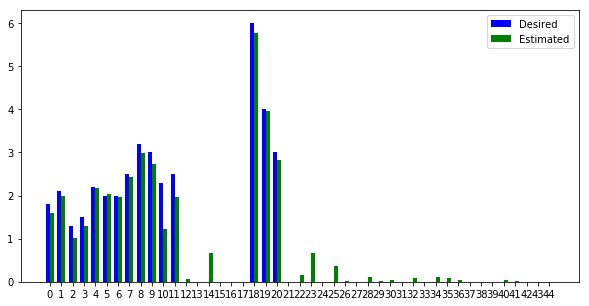

In [57]:
ana.plot_rates_bar(regulation_network.desired_rates, lsq_rates)

(100, 9)


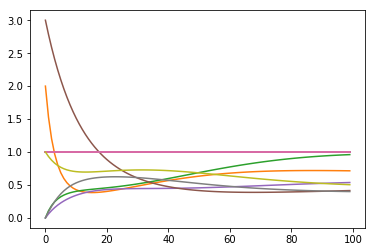

In [60]:
t = analysis.get_traj(4)
print(t.counts.shape)
plt.plot(t.counts)

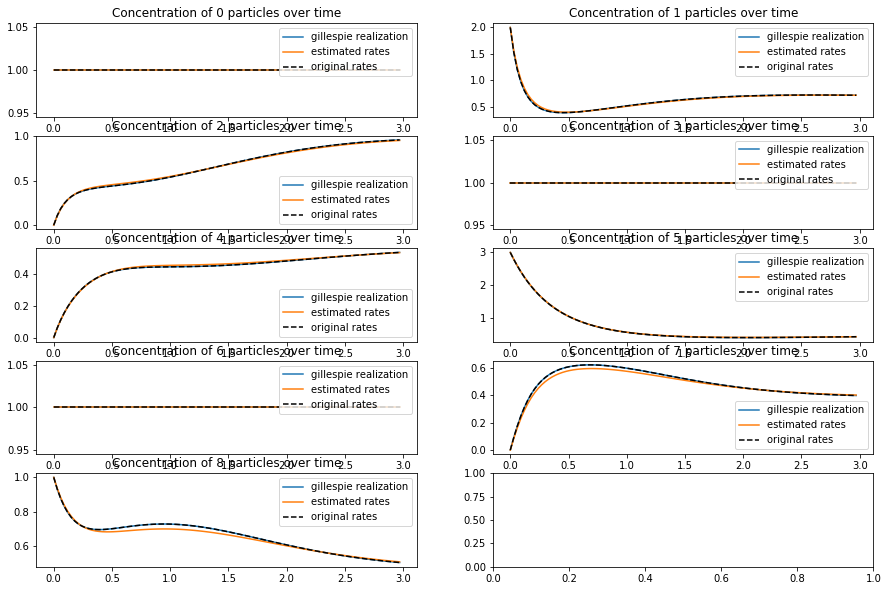

In [61]:
analysis.plot_results(4, lsq_rates)